In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# dictionary of places of interest for convenience,
# Clerkenwell was 51.5266
places = {'Buenos Aires':(-34.5798,-58.4422),
          'Clerkenwell':(51.5273,-0.1109),
          'Welwyn Garden City':(51.7938,-0.189),
          'Bromley':(51.395,-0.006)
         }

# OSMuf
OSMuf is a collection of functions which generate measures of urban form from OSM data. It builds on OSMnx and GeoPandas.

In [3]:
import pandas as pd

In [4]:
import osmuf as ouf
import osmnx as ox

## Define a study area, download and project primary OSM data
- Define a study area from point and distance
- Download OSM polygons tagged as 'place' from the same point and distance. Keep only those tagged as "place=city_block"
- Download OSM buildings and filter the attributes to the minimum
- Download OSM streets that overlap the city blocks - this is to ensure all of the buildings on a city block are downloaded and not clipped to the study area

Define a place name for the study, a centre point and a distance from the centre point to define the study area.

In [5]:
# choose one of the study areas
place_name = 'Bromley'
point = places[place_name]
distance = 500

In [6]:
# define study area
study_area = ouf.study_area_from_point(point, distance)

# include projected version temporarily to deal with rotation
study_area_prj = ouf.projected_study_area_from_point(point, distance)

# download urban blocks
city_blocks = ouf.places_from_point(point, distance)
# download buildings on the urban blocks
buildings = ouf.buildings_from_gdf(city_blocks)

# download streets around the urban blocks to polygonize
street_graph_for_blocks = ouf.street_graph_from_gdf(city_blocks)
streets_for_blocks = ouf.streets_from_street_graph(street_graph_for_blocks)

# download driveable streets to calculate network density
street_graph_for_networkd = ouf.street_graph_from_gdf(city_blocks,
                                                      network_type='drive')
streets_for_networkd = ouf.streets_from_street_graph(street_graph_for_networkd)

Project the dataframes to change from geographic coordinates (lat, long) to projected UTM (meters)

In [7]:
# project the dataframes to local UTM coordinates
# study_area_prj = ox.project_gdf(study_area)
city_blocks_prj = ox.project_gdf(city_blocks)
streets_for_blocks_prj = ox.project_gdf(streets_for_blocks)
streets_for_networkd_prj = ox.project_gdf(streets_for_networkd)
buildings_prj = ox.project_gdf(buildings)

Check alignment by plotting them:

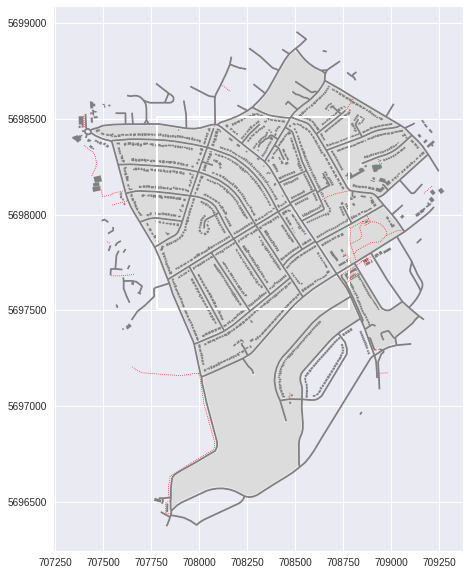

In [8]:
# display the dataframes to check their alignment
ax = city_blocks_prj.plot(figsize=(10,10), color='gainsboro')
buildings_prj.plot(ax=ax, color='grey')
streets_for_blocks_prj.plot(ax=ax, color='red', linewidth=0.75, linestyle=':')
streets_for_networkd_prj.plot(ax=ax, color='grey')
study_area_prj.plot(ax=ax, edgecolor='white',facecolor='None', linewidth=2)

## Generate secondary data

In [9]:
# generate gross city blocks from the street graph and net city blocks
gross_city_blocks = ouf.gen_gross_city_blocks(street_graph_for_blocks,
                                              city_blocks)

# project the new gross city blocks
gross_city_blocks_prj = ox.project_gdf(gross_city_blocks)

# calculate network density for each gross urban block
gross_city_blocks_prj = ouf.measure_network_density(streets_for_networkd_prj,
                                                    gross_city_blocks_prj)

# generate the footprint area and total GEA for each building
buildings_prj = ouf.measure_buildings(buildings_prj)

# join the id of the city block onto each building
buildings_prj = ouf.join_buildings_place_id(buildings_prj,
                                            city_blocks_prj)

# calculate the net_to_gross for the net_city_blocks
city_blocks_prj = ouf.measure_city_blocks(city_blocks_prj,
                                          gross_city_blocks_prj)

# calculate measures of the regularity of the net_city_blocks
city_blocks_form_factor = ouf.gen_regularity(city_blocks_prj)

# join the id of the city block onto each building
# buildings_prj = ouf.join_buildings_place_id(buildings_prj, city_blocks_prj)

# aggregate building measures and merge onto city blocks
city_blocks_prj = ouf.join_places_building_data(city_blocks_prj,
                                                buildings_prj)

# OSMuf Plots

## 1. Block Size

/home/nick/anaconda3/envs/osmnx_osmuf-dev/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


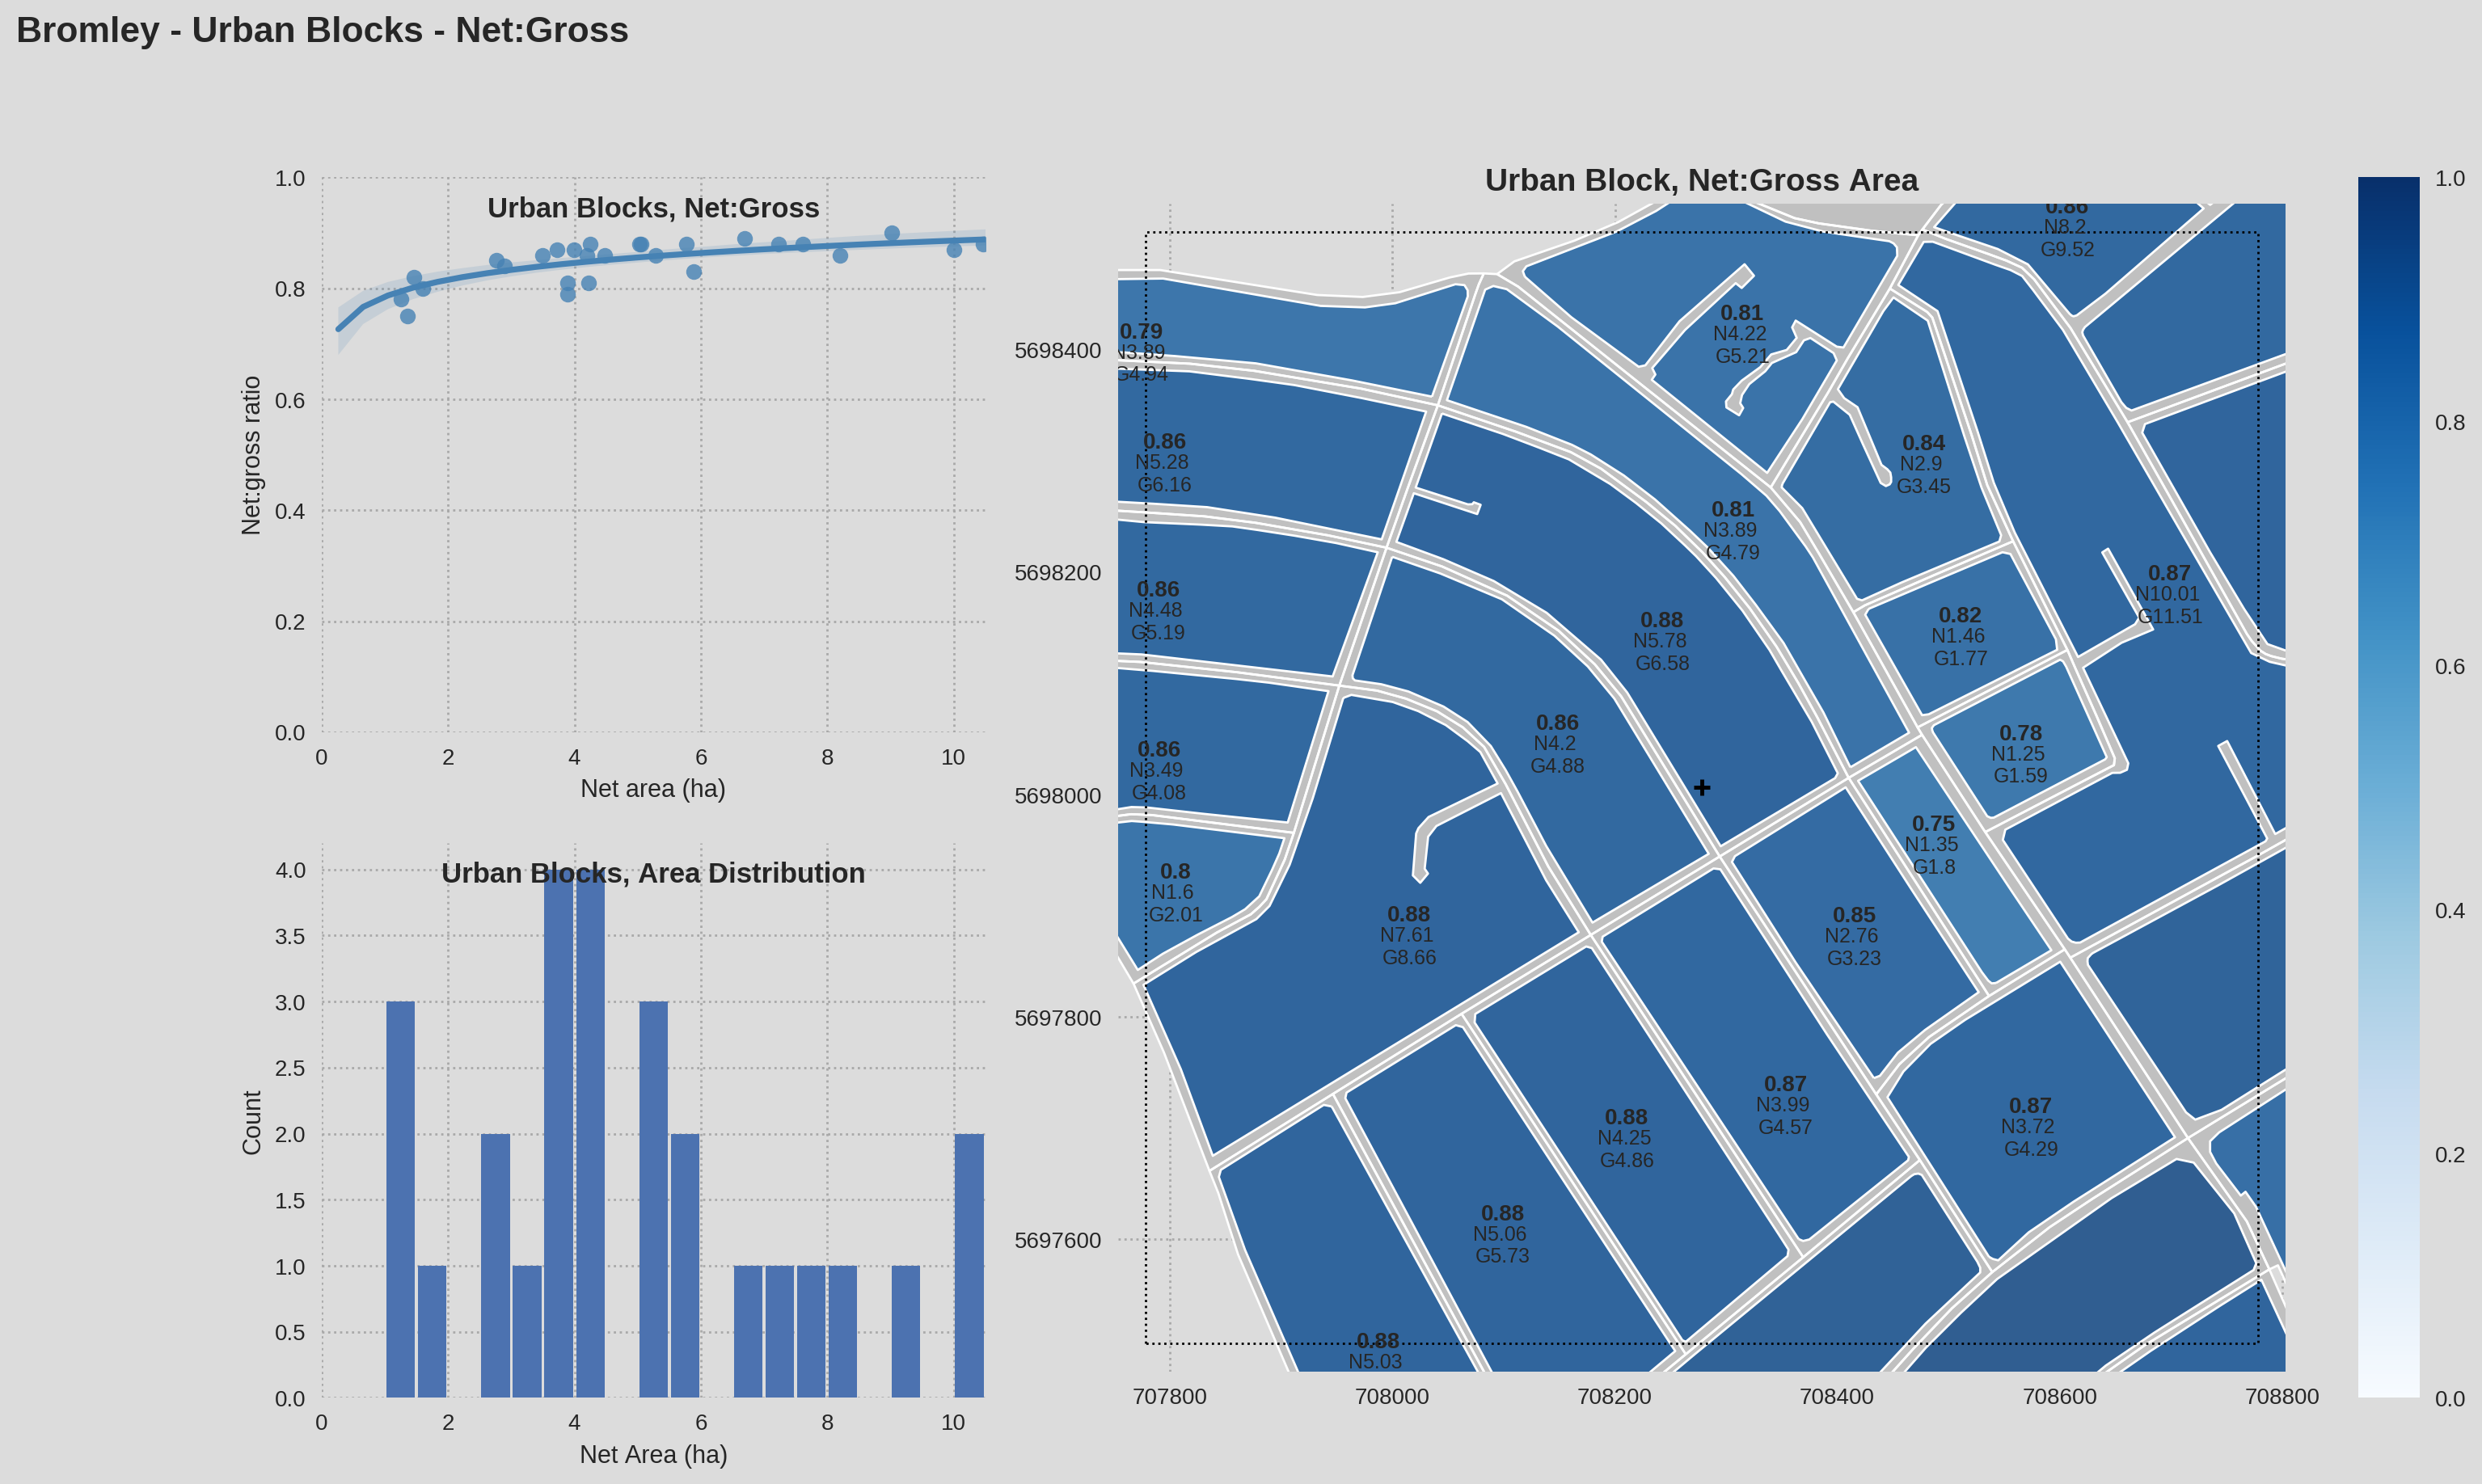

In [10]:
fig, ax = ouf.layout_3_plots()
fig.suptitle(place_name + ' - Urban Blocks - Net:Gross',
             fontsize=16, fontweight='bold', ha='left', x=0.02)

ouf.ax_block_ntg_to_size(ax[0], city_blocks_prj)

ouf.ax_block_area_distribution(ax[1], city_blocks_prj)

ouf.ax_map_block_size(ax[2], study_area_prj,
                      gross_city_blocks_prj, city_blocks_prj)

fig.savefig('../local_images/00_blocks_size_{}.png'.format(place_name),
            transparent=False, dpi=200, bbox_inches="tight",
            facecolor='gainsboro')

## 2. Form Factor

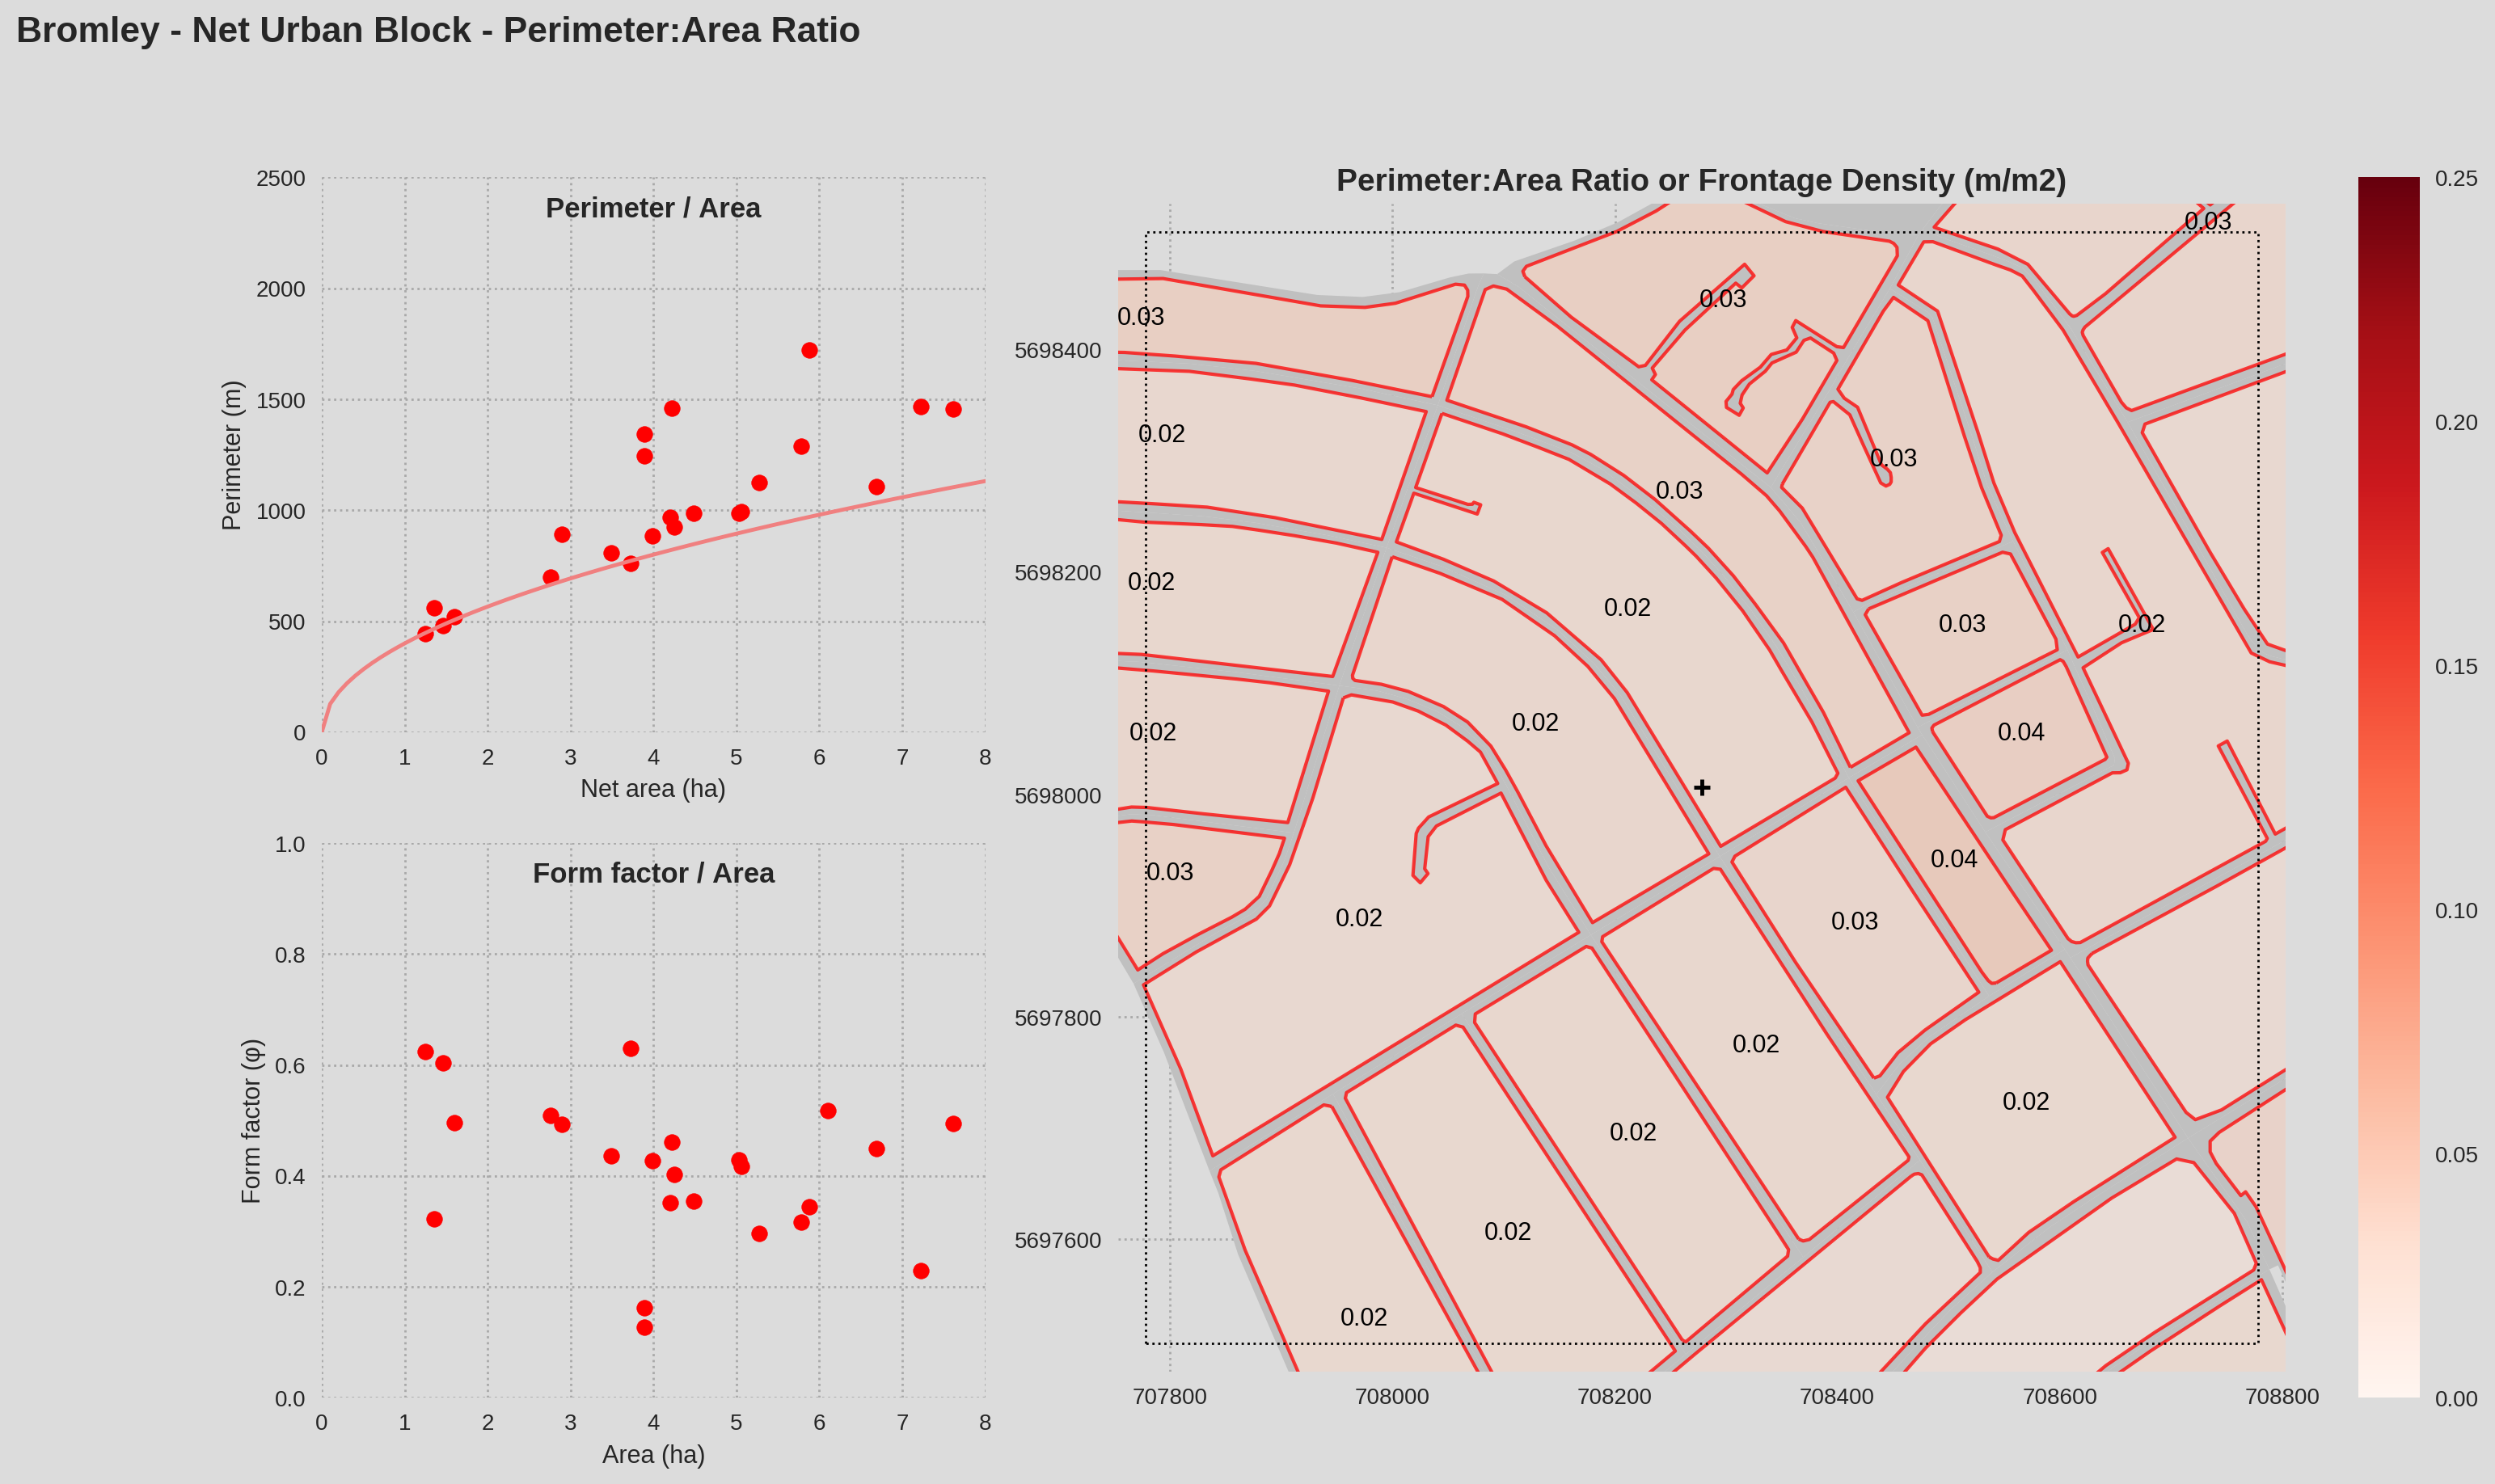

In [11]:
fig, ax = ouf.layout_3_plots()
fig.suptitle(place_name + ' - Net Urban Block - Perimeter:Area Ratio',
             fontsize=16, fontweight='bold', ha='left', x=0.02)

ouf.ax_block_perimeter_to_area(ax[0], city_blocks_prj)
ouf.ax_form_factor_to_area(ax[1], city_blocks_form_factor)
ouf.ax_map_form_factor(ax[2], study_area_prj, gross_city_blocks_prj,
                       city_blocks_prj, city_blocks_form_factor)

fig.savefig('../local_images/01_blocks_form_factor_{}.png'.format(place_name),
            transparent=False, dpi=200, bbox_inches="tight",
            facecolor='gainsboro')

# 3. Net Urban Block - GSI

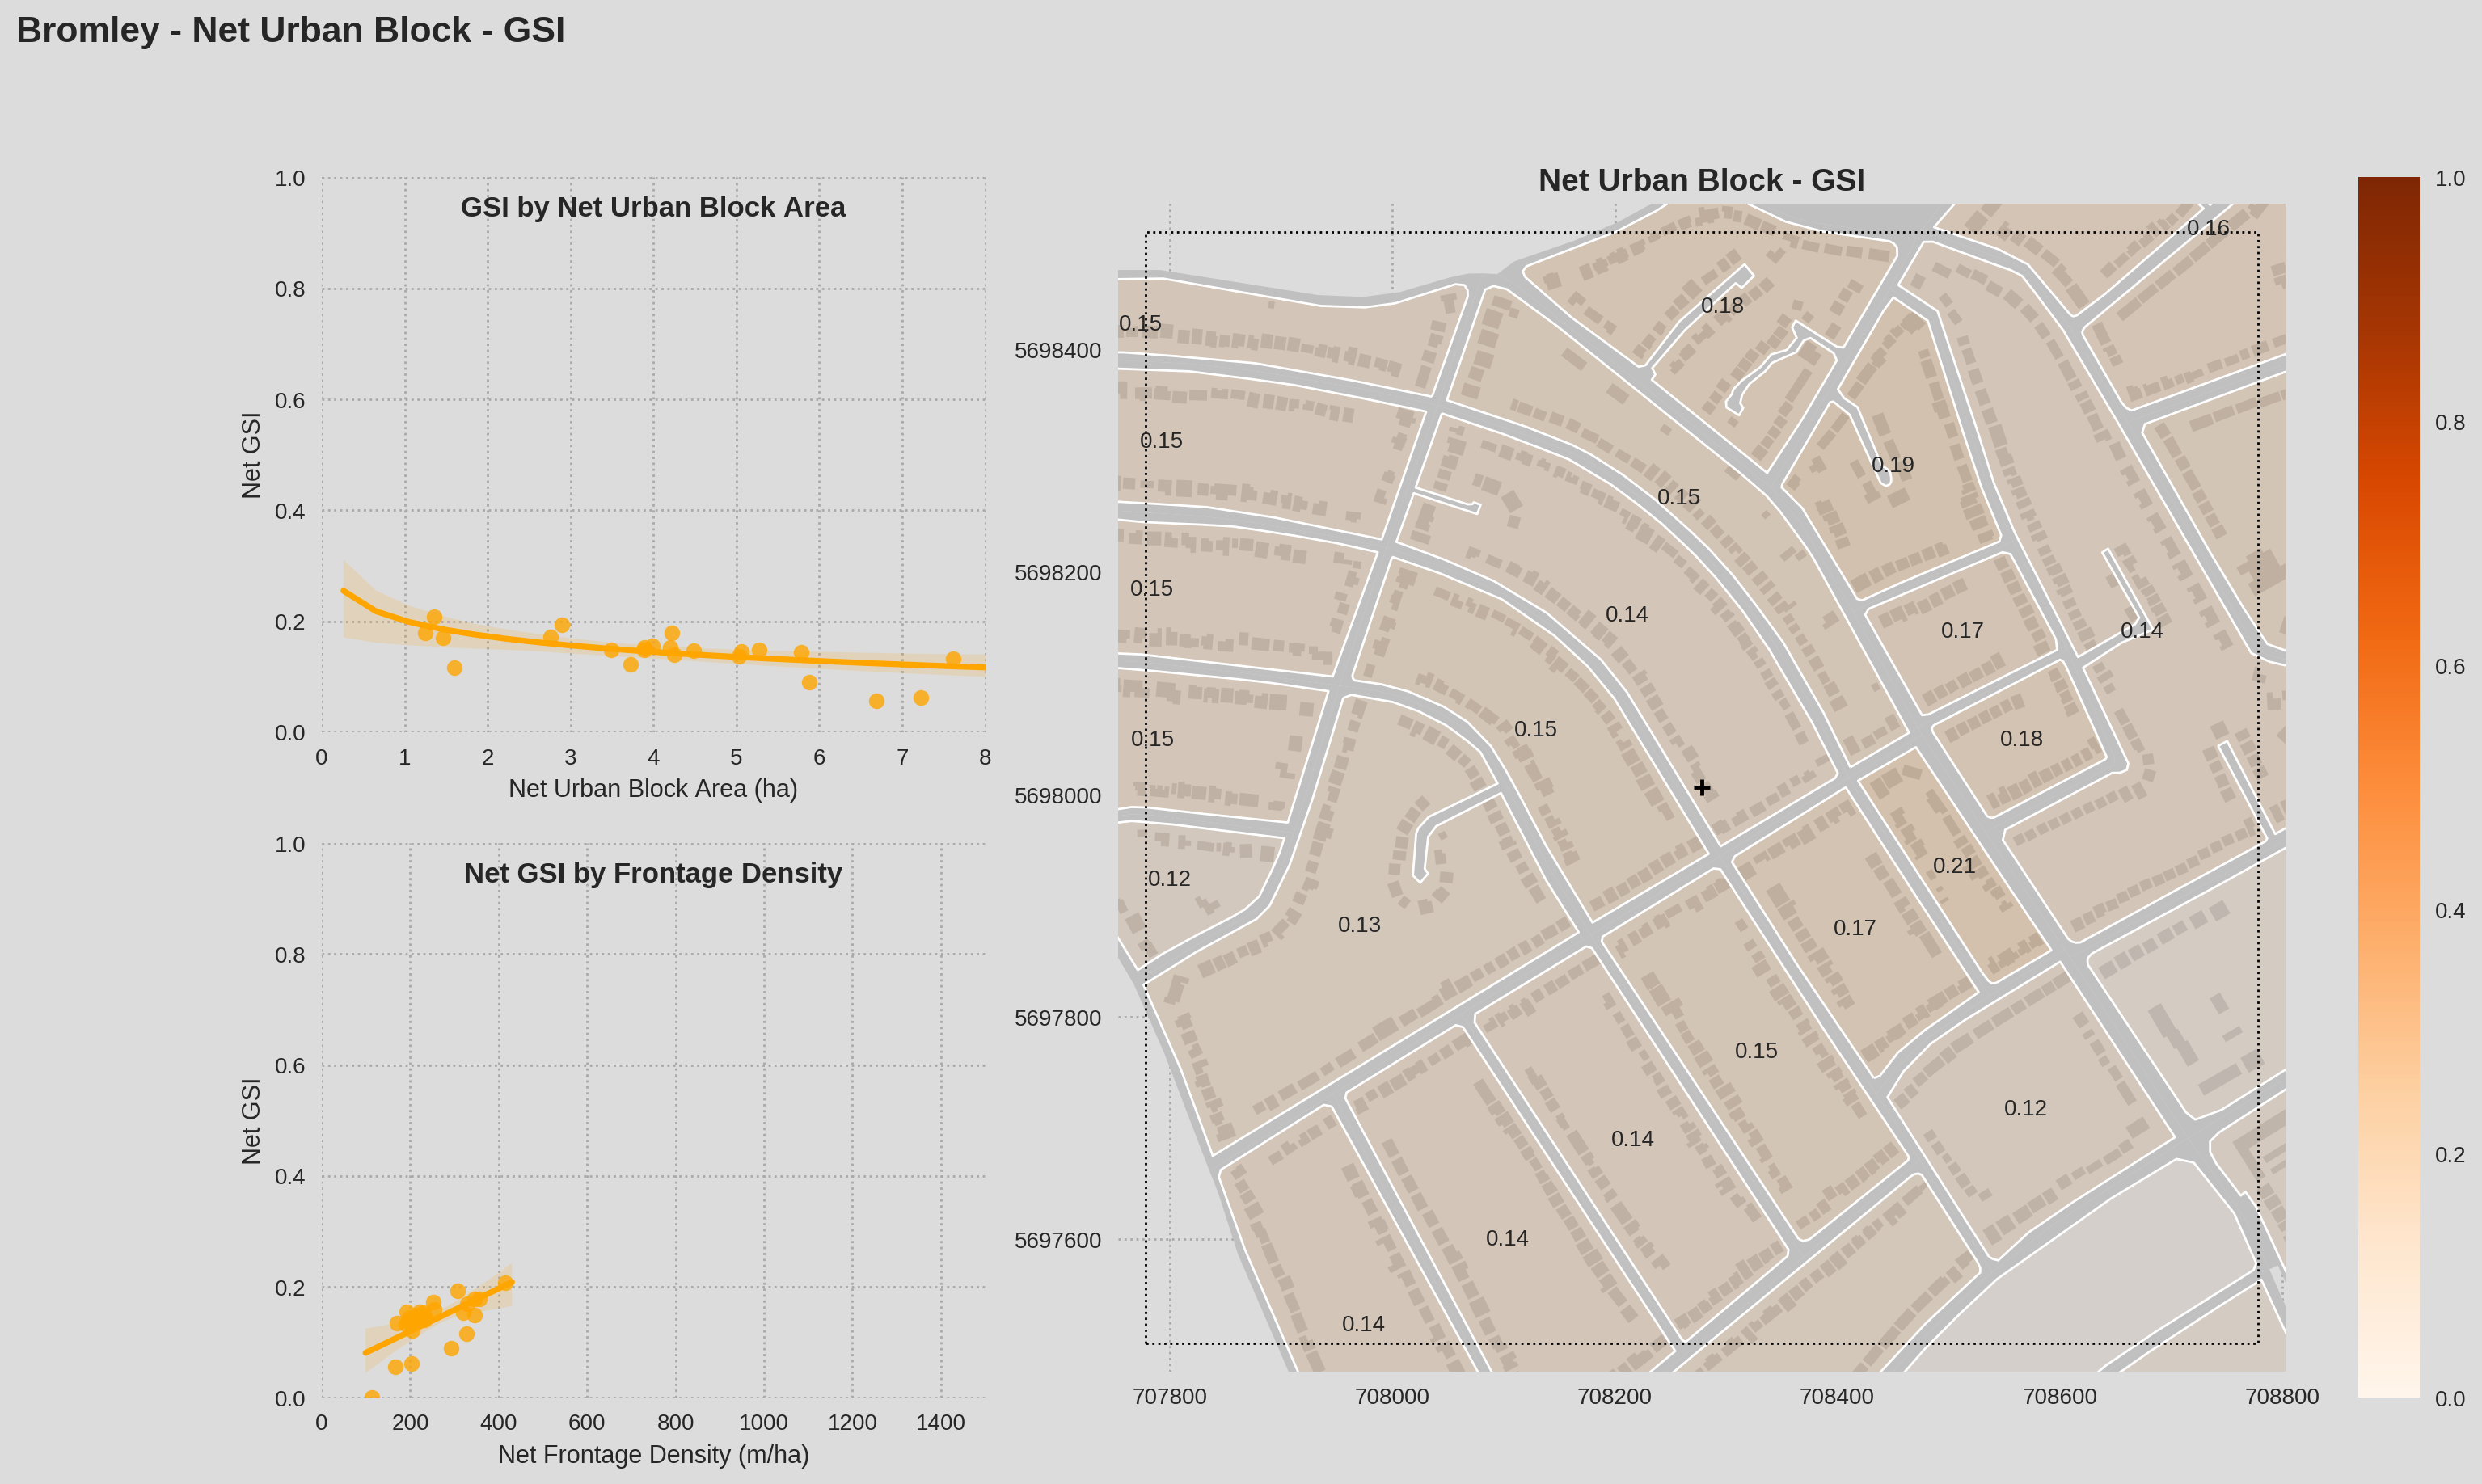

In [12]:
fig, ax = ouf.layout_3_plots()
fig.suptitle(place_name + ' - Net Urban Block - GSI', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

ouf.ax_net_GSI_to_net_area(ax[0], city_blocks_prj)
#ouf.ax_building_footprint_to_net_area(ax[0], city_blocks_prj)
ouf.ax_net_GSI_to_frontage_density(ax[1], city_blocks_prj)
#ouf.ax_GSI_distribution(ax[1], city_blocks_prj)
ouf.ax_map_GSI(ax[2], study_area_prj, gross_city_blocks_prj,
               city_blocks_prj, buildings_prj)

fig.savefig('../local_images/02_blocks_by_GSI_{}.png'.format(place_name),
            transparent=False, dpi=200, bbox_inches="tight",
            facecolor='gainsboro')

# 4. Building Heights

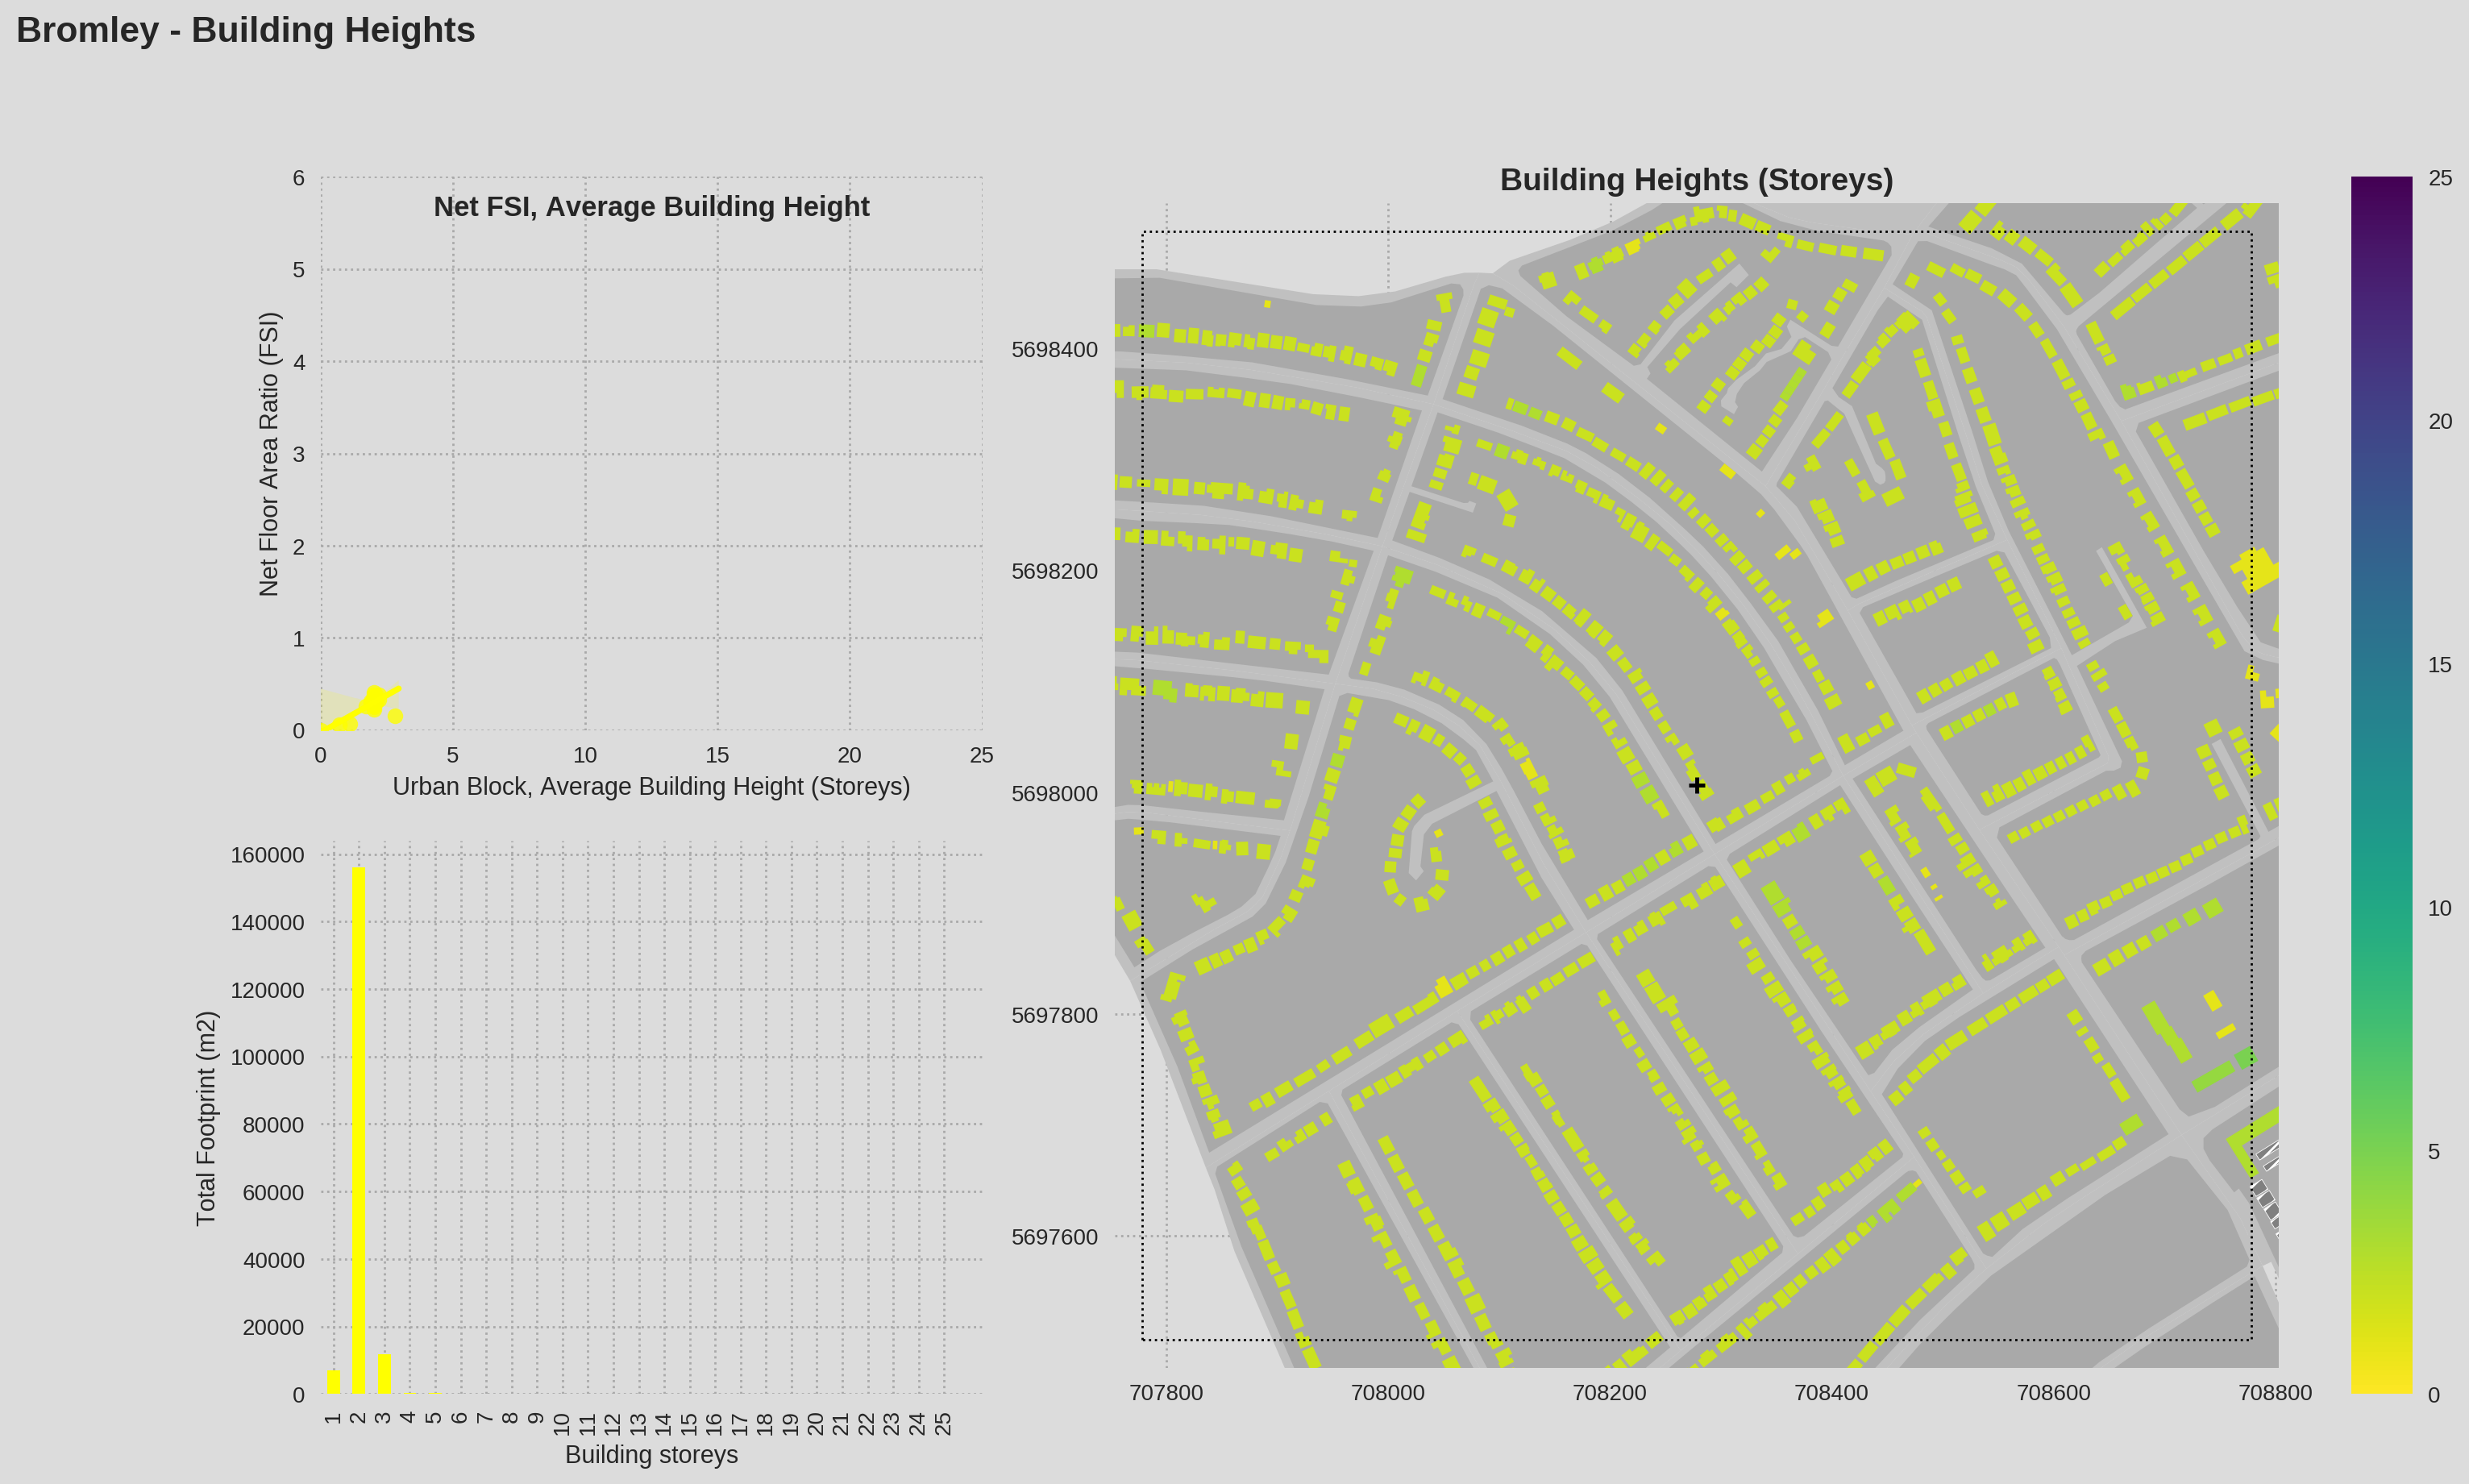

In [13]:
fig, ax = ouf.layout_3_plots()
fig.suptitle(place_name + ' - Building Heights', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

ouf.ax_net_FSI_to_avg_building_height(ax[0], city_blocks_prj)
ouf.ax_building_height_distribution_by_area(ax[1], buildings_prj)
ouf.ax_map_building_heights(ax[2], study_area_prj, gross_city_blocks_prj,
                            city_blocks_prj, buildings_prj)

fig.savefig('../local_images/04_building_heights_{}.png'.format(place_name),
            transparent=False, dpi=200, bbox_inches="tight",
            facecolor='gainsboro')

# 5. FSI

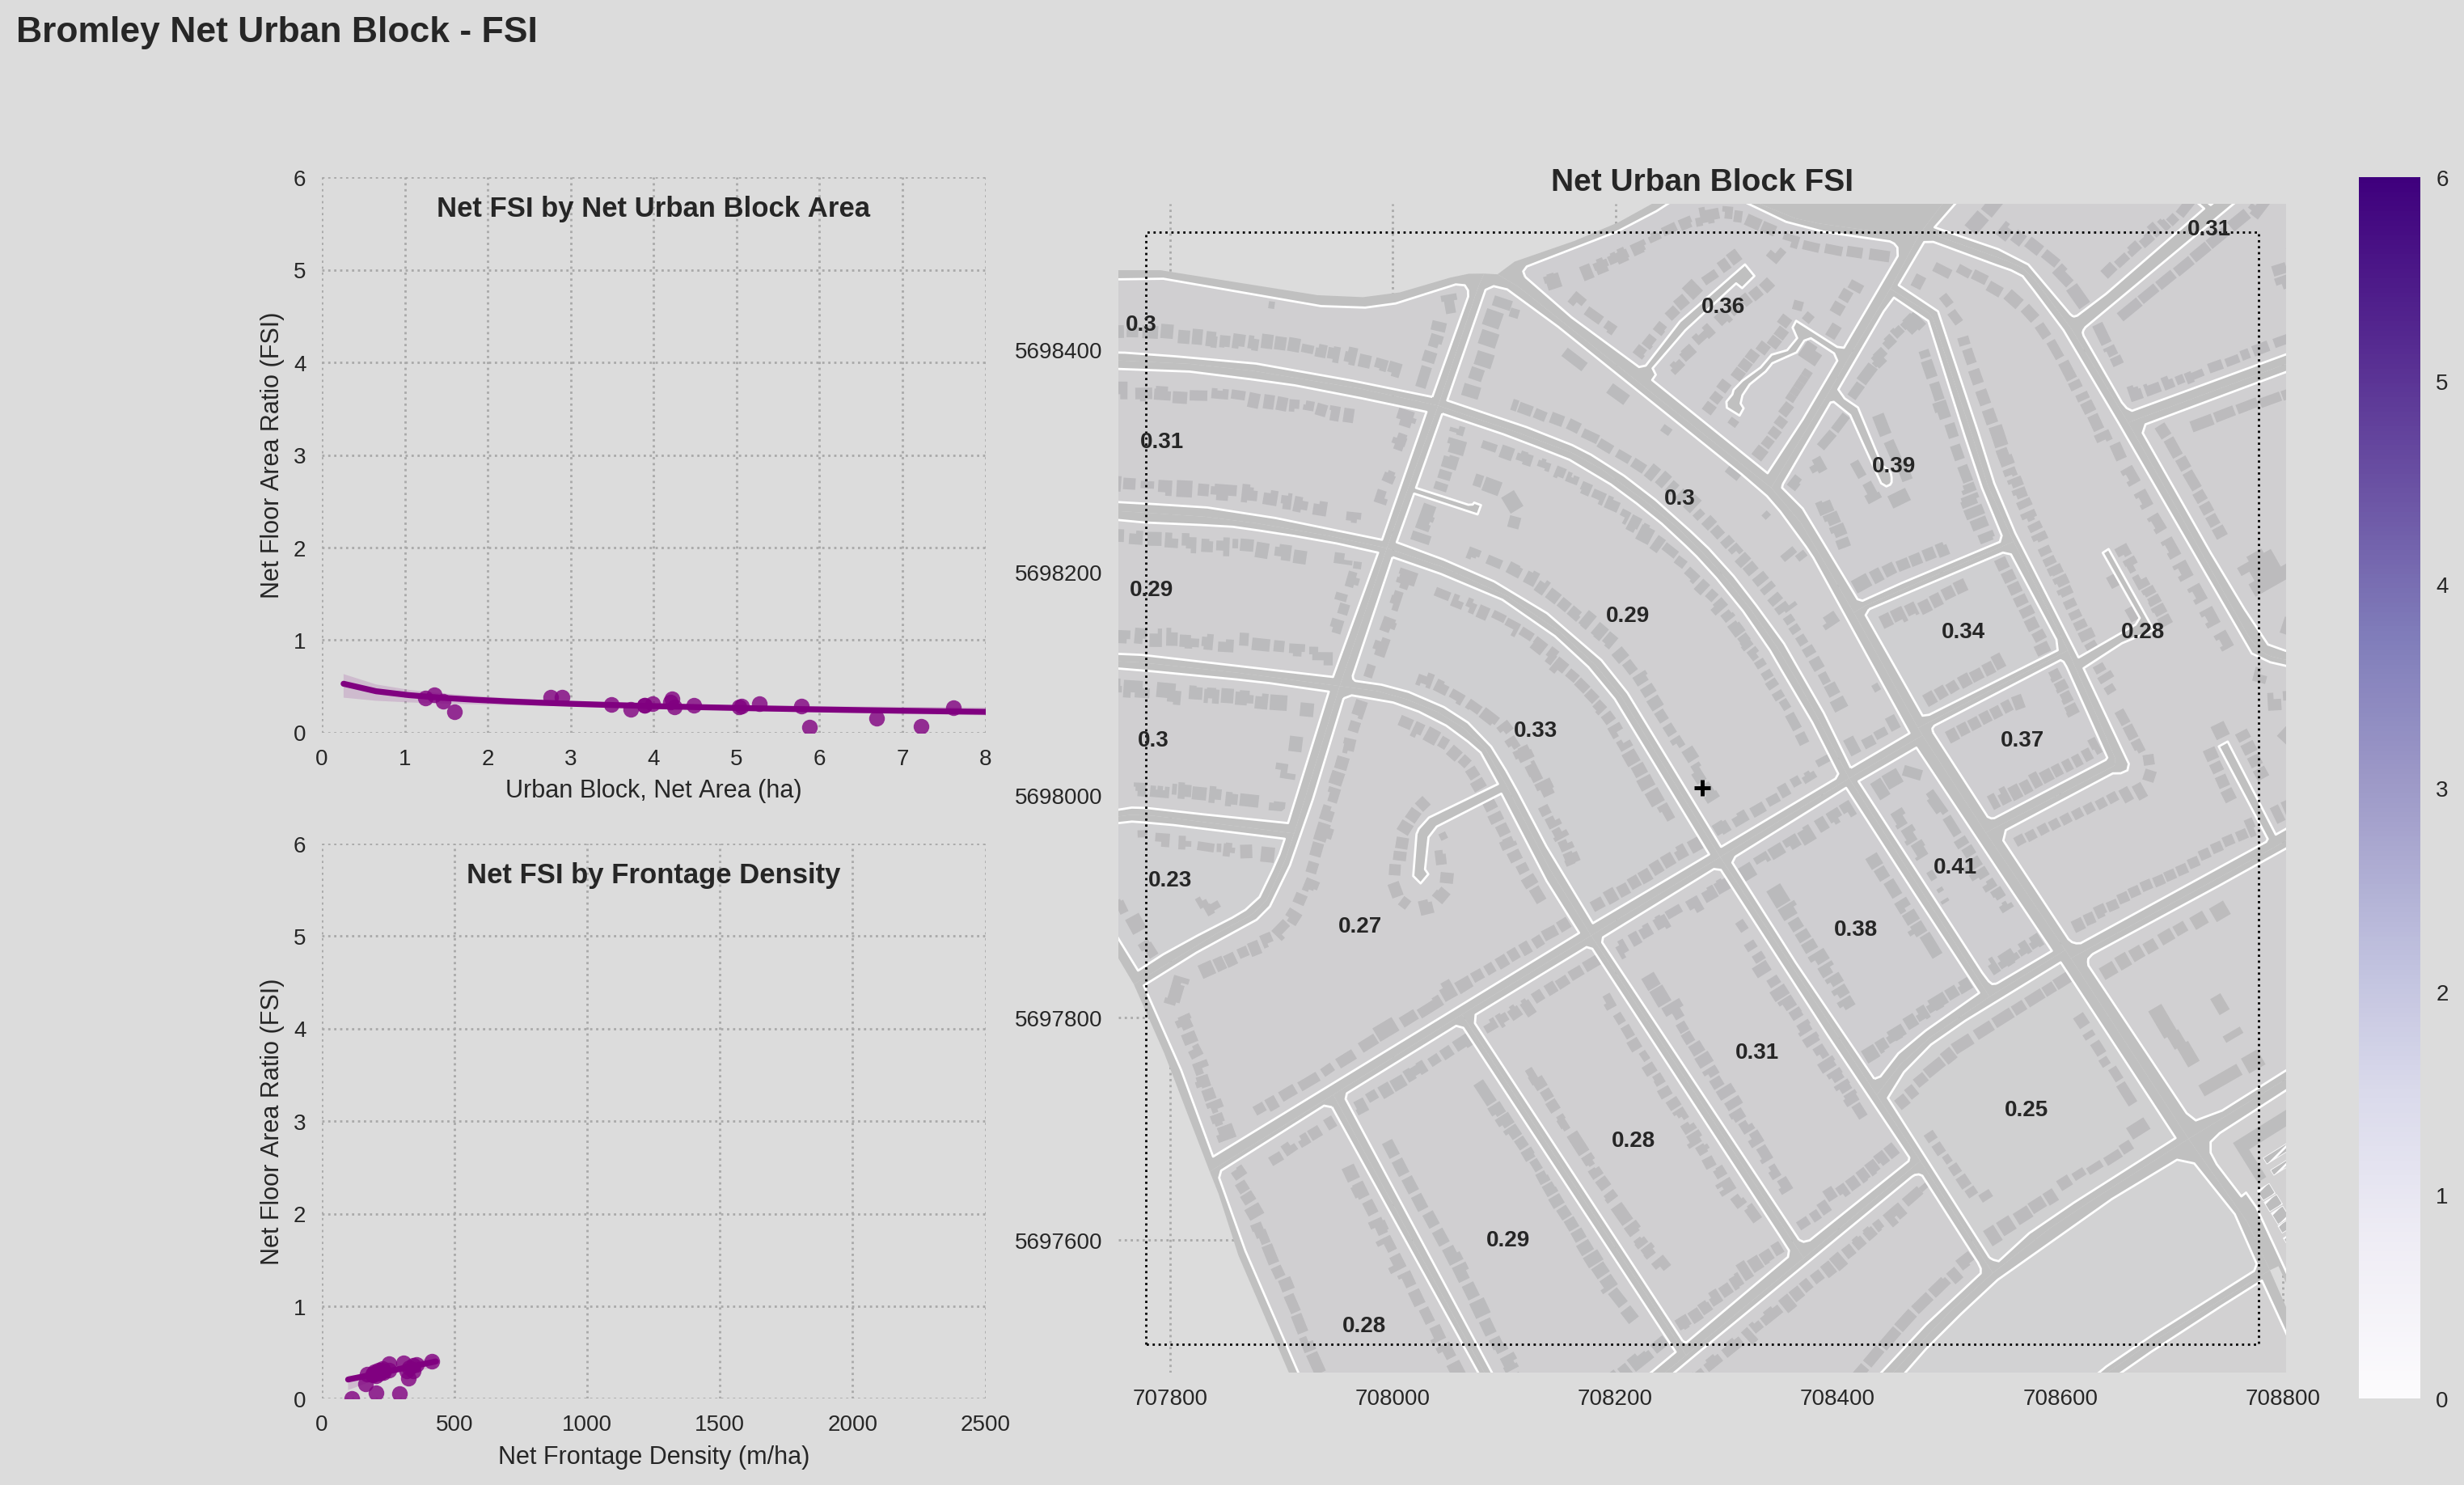

In [14]:
fig, ax = ouf.layout_3_plots()
fig.suptitle(place_name + ' Net Urban Block - FSI', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

# ouf.ax_gross_FSI_to_gross_area(ax[0], city_blocks_prj)
#ouf.ax_building_GEA_to_net_area(ax[0], city_blocks_prj)
ouf.ax_net_FSI_to_net_area(ax[0], city_blocks_prj)
###ouf.ax_gross_FSI_to_gross_frontage_density(ax[0], city_blocks_prj)
ouf.ax_net_FSI_to_frontage_density(ax[1], city_blocks_prj)
#ouf.ax_building_GEA_to_frontage(ax[1], city_blocks_prj)
ouf.ax_map_FSI(ax[2], study_area_prj, gross_city_blocks_prj,
               city_blocks_prj, buildings_prj)

fig.savefig('../local_images/04_blocks_by_FSI_{}.png'.format(place_name),
            transparent=False, dpi=200, bbox_inches="tight",
            facecolor='gainsboro')

# 6. Network Density

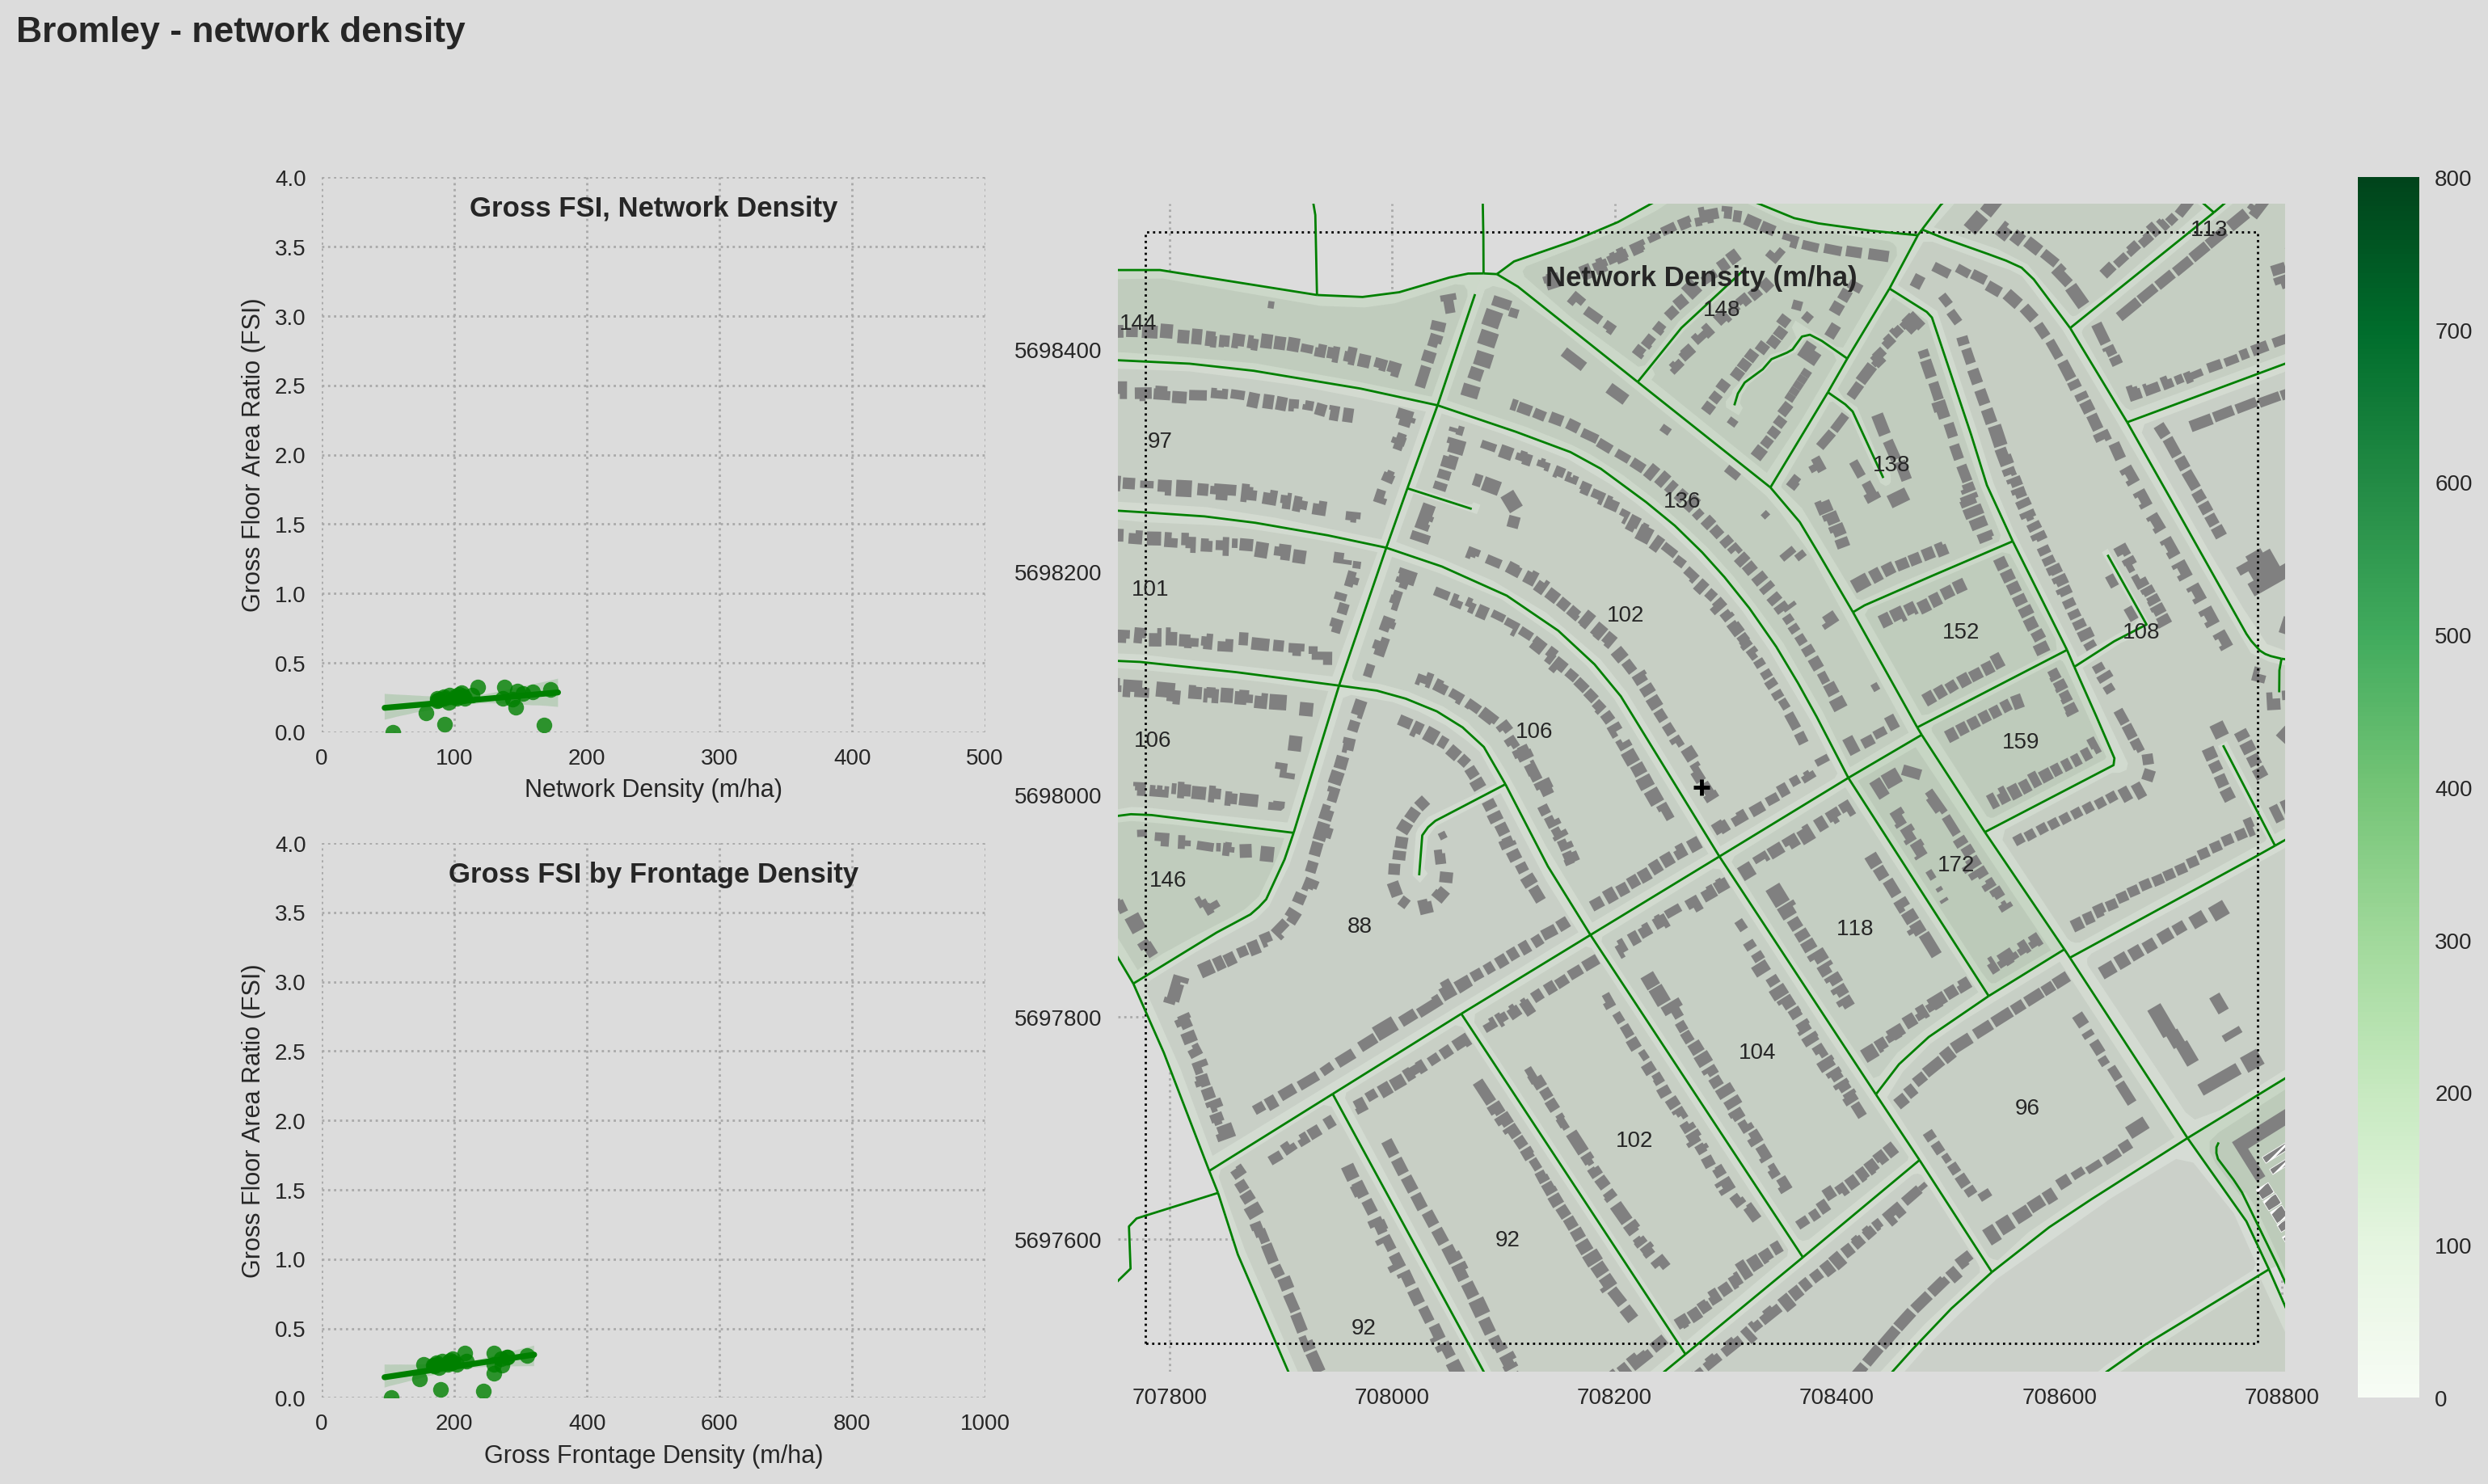

In [15]:
fig, ax = ouf.layout_3_plots()
fig.suptitle(place_name + ' - network density', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

# ouf.ax_gross_FSI_to_gross_area(ax[0], city_blocks_prj)
ouf.ax_gross_FSI_to_network_density(ax[0], city_blocks_prj)
### ouf.ax_network_density_to_gross_area(ax[1], gross_city_blocks_prj)
ouf.ax_gross_FSI_to_gross_frontage_density(ax[1], city_blocks_prj)
ouf.ax_map_network_density(ax[2], study_area_prj, gross_city_blocks_prj,
                           city_blocks_prj, buildings_prj,
                           streets_for_networkd_prj)

fig.savefig('../local_images/06_network_density_{}.png'.format(place_name),
            transparent=False, dpi=200, bbox_inches="tight",
            facecolor='gainsboro')